# Loading the data

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.datasets import boston_housing

In [32]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [33]:
train_data.shape

(404, 13)

In [34]:
test_data.shape

(102, 13)

In [35]:
train_targets[0:5]

array([15.2, 42.3, 50. , 21.1, 17.7])

# Preparing the data
we need to normalize the data, we will do feature-wise normalization
ie., subtract the mean of feature and divide by standard deviation

In [36]:
# normalize the data
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

In [37]:
train_data[0]

array([-0.27224633, -0.48361547, -0.43576161, -0.25683275, -0.1652266 ,
       -0.1764426 ,  0.81306188,  0.1166983 , -0.62624905, -0.59517003,
        1.14850044,  0.44807713,  0.8252202 ])

# Building your network

In [38]:
def build_model():
  model = keras.Sequential([
                            layers.Dense(64, activation='relu'),
                            layers.Dense(64, activation='relu'),
                            layers.Dense(1)
  ])

  model.compile(optimizer='rmsprop',
              loss='mse', metrics=['mae'])
  return model  

# Validating using K-fold validation

In [39]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):

  # prepare the validation data : data from partition #k
  print('Processing fold #%d' % i)
  val_data = train_data[i*num_val_samples : (i+1)*num_val_samples]
  val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]

  # prepare the training data : data from all other partitions
  partial_train_data = np.concatenate(
      [train_data[:i*num_val_samples],
       train_data[(i+1)*num_val_samples:]],
       axis=0
  )

  partial_train_targets = np.concatenate(
      [train_targets[:i*num_val_samples],
       train_targets[(i+1)*num_val_samples:]],
       axis=0
  )

  model = build_model()

  model.fit(partial_train_data,
            partial_train_targets,
            epochs=num_epochs,
            batch_size=1,
            verbose=0)
  
  val_mes, val_mae = model.evaluate(val_data, val_targets,verbose=0)

  all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [ ]:
all_scores

In [ ]:
np.mean(all_scores)

# Saving the validation logs at each fold

In [44]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
  print('processing fold #%d' % i)
  val_data = train_data[i*num_val_samples : (i+1)*num_val_samples]
  val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]
  
  partial_train_data = np.concatenate(
      [train_data[:i*num_val_samples],
       train_data[(i+1)*num_val_samples:]], 
       axis=0
  )
  partial_train_targets = np.concatenate(
      [train_targets[:i*num_val_samples],
       train_targets[(i+1)*num_val_samples:]],
       axis=0
  )

  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets,
                      validation_data=(val_data, val_targets),
                      epochs=num_epochs, batch_size=1, verbose=0)
  
  mae_history = history.history['val_mae']
  all_mae_histories.append(mae_history)

processing fold #0
processing fold #1
processing fold #2
processing fold #3


# Building the history of successive mean K_fold validation data

In [45]:
average_mae_history = [
                       np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

# Plotting the validation scores

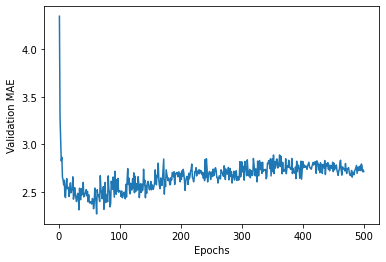

In [46]:
plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# It is difficult to see the plot due to scaling issues and relatively high variance. Let's do this:
- omit first 10 data points which are on different scale
- replace each point with an exponential moving average of the previous points, to obtain smooth curve

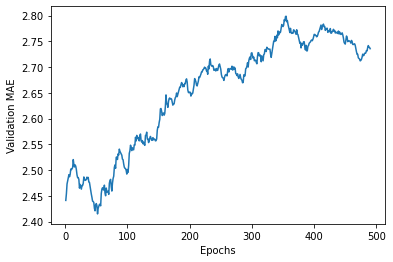

In [47]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1-factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

This shows the validating MAE by epoch, excluding the first 10 data points.  
According to this plot, MAE stops improving significantly after 80 epochs.

# Training the final model

In [48]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

test_mae_score

4/4 [==============================] - 0s 4ms/step - loss: 15.3611 - mae: 2.5636


2.5635716915130615